In [1]:
import polars as pl
import numpy as np

from data_valuation.core.loo_valuator import LOOValuator
from data_valuation.core.shapley_valuator import ShapleyValuator
from data_valuation.core.dvrl_valuator import DVRLValuator
from data_valuation.utils.data_utils import get_min_max_scores

/Users/takumishibata/Documents/project/data-valuation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1. Load ASAP dataset

In [2]:
def scale_score(score: int, essay_set: int, score_dict: dict) -> float:
    minscore, maxscore = score_dict[essay_set]['score']
    return (score - minscore) / (maxscore - minscore)

In [3]:
PROMPT_ID = 1
RAMDOM_SEED = 42

asap_data = pl.read_excel('training_set_rel3.xlsx')
asap_data = asap_data.drop_nulls("domain1_score")
asap_data = asap_data.select(['essay_id', 'essay_set', 'essay', 'domain1_score'])
asap_data = asap_data.with_columns(
    pl.struct(['domain1_score', 'essay_set'])
    .map_elements(lambda x: scale_score(x['domain1_score'], x['essay_set'], get_min_max_scores()), return_dtype=pl.Float64)
    .alias('scaled_score')
)
asap_data = asap_data.filter(pl.col('essay_set') == PROMPT_ID)
asap_data

Could not determine dtype for column 5, falling back to string
Could not determine dtype for column 7, falling back to string
Could not determine dtype for column 8, falling back to string
Could not determine dtype for column 9, falling back to string
Could not determine dtype for column 10, falling back to string
Could not determine dtype for column 11, falling back to string
Could not determine dtype for column 12, falling back to string
Could not determine dtype for column 13, falling back to string
Could not determine dtype for column 14, falling back to string
Could not determine dtype for column 15, falling back to string
Could not determine dtype for column 16, falling back to string
Could not determine dtype for column 17, falling back to string
Could not determine dtype for column 18, falling back to string
Could not determine dtype for column 19, falling back to string
Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, fal

essay_id,essay_set,essay,domain1_score,scaled_score
i64,i64,str,i64,f64
1,1,"""Dear local newspaper, I think …",8,0.6
2,1,"""Dear @CAPS1 @CAPS2, I believe …",9,0.7
3,1,"""Dear, @CAPS1 @CAPS2 @CAPS3 Mor…",7,0.5
4,1,"""Dear Local Newspaper, @CAPS1 I…",10,0.8
5,1,"""Dear @LOCATION1, I know having…",8,0.6
…,…,…,…,…
1783,1,"""Dear @CAPS1, @CAPS2 several re…",8,0.6
1784,1,"""Do a adults and kids spend to …",7,0.5
1785,1,"""My opinion is that people shou…",8,0.6


In [4]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(asap_data, train_size=0.6, random_state=RAMDOM_SEED)
dev_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=RAMDOM_SEED)

print(f"Train data size: {train_data.shape}")
print(f"Dev data size: {dev_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (1069, 5)
Dev data size: (357, 5)
Test data size: (357, 5)


# Step 2. Add noise

In [5]:
def add_noise(data: pl.DataFrame, noise_ratio: float, noise_range: tuple, seed: int) -> pl.DataFrame:
    np.random.seed(seed)
    noise_indices = np.random.choice(data.shape[0], int(data.shape[0] * noise_ratio), replace=False)
    noise = np.random.uniform(noise_range[0], noise_range[1], len(noise_indices))

    noisy_scores = data['scaled_score'].to_numpy().copy()
    noisy_scores[noise_indices] += noise
    noisy_scores = np.clip(noisy_scores, 0, 1)  # Clipping

    data = data.with_columns(pl.Series(noisy_scores).alias('noisy_score'))

    is_noisy = np.zeros(data.shape[0], dtype=bool)
    is_noisy[noise_indices] = True
    data = data.with_columns(pl.Series(is_noisy).alias('is_noisy'))
    return data

train_data = add_noise(train_data, noise_ratio=0.2, noise_range=(0.4, 0.6), seed=RAMDOM_SEED)
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy
i64,i64,str,i64,f64,f64,bool
1666,1,"""Dear @LOCATION1 press, I have …",9,0.7,0.7,false
1530,1,"""To: @ORGANIZATION1 goes so fas…",8,0.6,0.6,false
884,1,"""Dear local newspaper, I've hea…",8,0.6,1.0,true
1473,1,"""Dear local news paper, This pa…",6,0.4,0.872612,true
733,1,"""Honestly, I totally and absolu…",8,0.6,0.6,false
…,…,…,…,…,…,…
1134,1,"""Dear sir, I belive that comput…",6,0.4,0.4,false
1299,1,"""Dear @PERSON2, Have you ever n…",11,0.9,0.9,false
863,1,"""Dear @CAPS1, @CAPS2 are very d…",10,0.8,0.8,false


# Step 3. Choose Valuation Type

In [ ]:
# Leave-One-Out Valuation
valuator = LOOValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    wandb_logging=True, # if you want to log the results to wandb
    wandb_project='data-valuation-test', # if you want to log the results to wandb
    wandb_name=f'LOO-Noise-Detection-Prompt-{PROMPT_ID}', # if you want to log the results to wandb
    # embedding_model='microsoft/deberta-v3-large',
    embedding_model='bert-base-uncased',
)

In [ ]:
# Data Shapley Valuation
valuator = ShapleyValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    wandb_logging=True,
    wandb_project='data-valuation-test',
    wandb_name=f'Shapley-Noise-Detection-Prompt-{PROMPT_ID}',
    embedding_model='bert-base-uncased',
)

In [6]:
# Data Valuation with Reinforcement Learning (DVRL)
valuator = DVRLValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    wandb_logging=True,
    wandb_project='data-valuation-test',
    wandb_name=f'DVRL-Noise-Detection-Prompt-{PROMPT_ID}',
    embedding_model='bert-base-uncased',
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



=== DVRLValuator Hyperparameters ===
Prompt ID: 1
Device: cpu
Seed: 42
Metric: qwk
Embedding Model: bert-base-uncased
Max Length: 512
Hidden Dimension: 100
Combination Dimension: 10
Iterations: 1000
Inner Iterations: 100
Batch Size: 10000
Learning Rate: 0.001
Predictor Batch Size: 512
Model Type: mlp
Epsilon: 1e-08
Threshold: 0.9



wandb: Currently logged in as: shibata to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training DVRL: 100%|██████████| 1000/1000 [20:05<00:00,  1.21s/it]


dvrl_loss,▂▇▃▅█▅▆▅▆▆▃▇▆▄▁▂▇▃▂▆▃▆▆▅▄▃▅▂▄▅▅▄▄▆▄▇▃▄▅▄
iteration,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
max_prob,▁▁▃▃▄▇▇███▆▆▆▆▆▂▂▂▂▁▂▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆
min_prob,▂▂▄▇▇██▆▆▆▇▅▃▂▃▁▁▁▂▂▃▄▆▆▆▅▆▆▇▇▇▆▆▆▆▆▆▆▆▆
qwk,▆▂▃▄▄▄▆▄▅▃▄▁▇▃▂█▆▂▄▃▃█▆▄▃▄▄▇▆▅▃▂▄▇▁▄▅▆▆█
reward,▄▁▆█▇▆▃▅█▁▅▆▅▄▆▆▆▄▇▃▅▆▆▂▅▄▄▇▄▆▄▇█▄▅▇█▇▅▆
dvrl_loss,26.87365
iteration,999
max_prob,0.56692
min_prob,0.55449
qwk,0.6772


Values saved to ./shapley_values_1.csv


# Step 4. Estimate Data Values

In [7]:
estimated_values = valuator.estimate_values(
    x_train=train_data['essay'].to_list(),
    y_train=train_data['noisy_score'].to_numpy(),
    x_val=dev_data['essay'].to_list(),
    y_val=dev_data['scaled_score'].to_numpy(),
    sample_ids=train_data['essay_id'].to_numpy(),
)

# Save the estimated values
valuator.save_values(estimated_values, f'./output_files/estimated_values_{PROMPT_ID}.csv')

# Load the estimated values as DataFrame
value_df = pl.DataFrame({'essay_id': estimated_values.keys(), 'value': estimated_values.values()})

NameError: name 'estimated_values' is not defined

# Step 5. Discover corrupted sample

In [10]:
train_data = train_data.join(value_df, on='essay_id', how='left')
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy,value
i64,i64,str,i64,f64,f64,bool,f64
1666,1,"""Dear @LOCATION1 press, I have …",9,0.7,0.7,false,0.567093
1530,1,"""To: @ORGANIZATION1 goes so fas…",8,0.6,0.6,false,0.566265
884,1,"""Dear local newspaper, I've hea…",8,0.6,1.0,true,0.560252
1473,1,"""Dear local news paper, This pa…",6,0.4,0.872612,true,0.559079
733,1,"""Honestly, I totally and absolu…",8,0.6,0.6,false,0.56729
…,…,…,…,…,…,…,…
1134,1,"""Dear sir, I belive that comput…",6,0.4,0.4,false,0.565537
1299,1,"""Dear @PERSON2, Have you ever n…",11,0.9,0.9,false,0.566084
863,1,"""Dear @CAPS1, @CAPS2 are very d…",10,0.8,0.8,false,0.566285


array([0.23943662, 0.46948357, 0.69483568, 0.85446009, 0.96713615,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

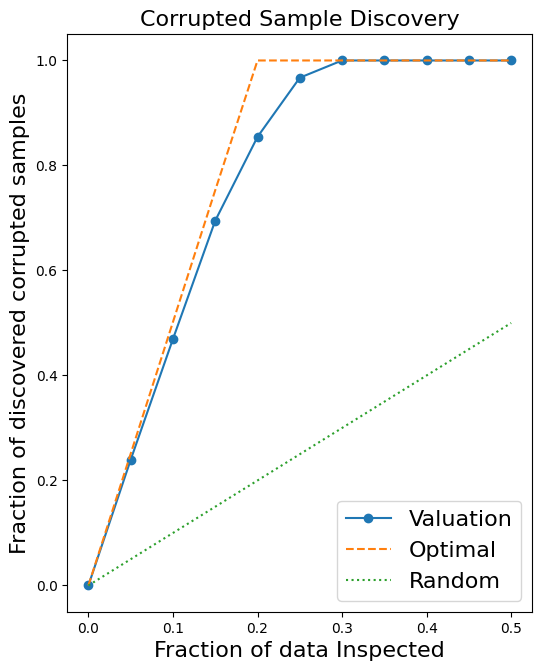

In [11]:
import matplotlib.pyplot as plt

def discover_corrupted_sample(dve_out, noise_mask, noise_rate, output_path=None, plot=True):
  """Reports True Positive Rate (TPR) of corrupted label discovery.

  Args:
    dve_out: data values (numpy array)
    noise_mask: 各サンプルがノイズか否かを示す True/False のブール配列
    noise_rate: ノイズサンプルの割合
    output_path: プロット画像の出力先パス
    plot: プロットを表示するかどうか

  Returns:
    output_perf: パーセンタイル毎（例: 5%刻み）に算出したノイズ検出率（TPR）
  """

  # サンプルをデータ値でソート
  num_bins = 20  # 100%を20分割
  sort_idx = np.argsort(dve_out)

  # 出力用初期化
  output_perf = np.zeros([num_bins,])
  total_noise = np.sum(noise_mask)  # 全ノイズサンプル数

  # 各パーセンタイルごとに計算
  for itt in range(num_bins):
    num_samples = int((itt+1) * len(dve_out) / num_bins)
    # 現在の範囲内でのノイズサンプル数をカウント
    discovered_noise = np.sum(noise_mask[sort_idx[:num_samples]])
    output_perf[itt] = discovered_noise / total_noise

  # ノイズ検出率のグラフをプロット
  if plot:
    num_x = int(num_bins / 2 + 1)
    x = [a * (1.0 / num_bins) for a in range(num_x)]
    y_dvrl = np.concatenate((np.zeros(1), output_perf[:(num_x - 1)]))
    y_opt = [min(a * ((1.0 / num_bins) / noise_rate), 1) for a in range(num_x)]
    y_random = x

    plt.figure(figsize=(6, 7.5))
    plt.plot(x, y_dvrl, 'o-')
    plt.plot(x, y_opt, '--')
    plt.plot(x, y_random, ':')
    plt.xlabel('Fraction of data Inspected', size=16)
    plt.ylabel('Fraction of discovered corrupted samples', size=16)
    plt.legend(['Valuation', 'Optimal', 'Random'], prop={'size': 16})
    plt.title('Corrupted Sample Discovery', size=16)
    if output_path:
        plt.savefig(output_path + 'corrupted_sample_discovery.png')

  # ノイズ検出率 (TPR) を返す
  return output_perf

# Assuming 'value' column contains the data values
dve_out = train_data['value'].to_numpy()
# Assuming 'is_noisy' column indicates corrupted samples (True for corrupted)
noise_mask = train_data['is_noisy'].to_numpy()
noise_rate = train_data['is_noisy'].mean()  # Calculate the noise rate

# Call the function and plot
discover_corrupted_sample(dve_out, noise_mask, noise_rate)

# Step 6. Calculate F1 score

In [12]:
from sklearn.cluster import KMeans

# Extract the 'value' column for clustering
values = train_data['value'].to_numpy().reshape(-1, 1)

# Perform KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
train_data = train_data.with_columns(pl.Series(kmeans.fit_predict(values)).alias("cluster"))

# Calculate the mean value for each cluster
cluster_means = train_data.group_by("cluster").agg([pl.mean("value").alias("mean_value")])

# Determine which cluster has higher mean value
high_value_cluster = cluster_means.filter(pl.col("mean_value") == cluster_means["mean_value"].max())["cluster"][0]

# Assign 'is_noisy_kmeans' based on cluster assignment: 
#  - False if in the cluster with higher mean value
#  - True otherwise
train_data = train_data.with_columns(
    (pl.col("cluster") != high_value_cluster).alias("is_noisy_kmeans")
)
train_data = train_data.drop("cluster")
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy,value,is_noisy_kmeans
i64,i64,str,i64,f64,f64,bool,f64,bool
1666,1,"""Dear @LOCATION1 press, I have …",9,0.7,0.7,false,0.567093,false
1530,1,"""To: @ORGANIZATION1 goes so fas…",8,0.6,0.6,false,0.566265,false
884,1,"""Dear local newspaper, I've hea…",8,0.6,1.0,true,0.560252,true
1473,1,"""Dear local news paper, This pa…",6,0.4,0.872612,true,0.559079,true
733,1,"""Honestly, I totally and absolu…",8,0.6,0.6,false,0.56729,false
…,…,…,…,…,…,…,…,…
1134,1,"""Dear sir, I belive that comput…",6,0.4,0.4,false,0.565537,false
1299,1,"""Dear @PERSON2, Have you ever n…",11,0.9,0.9,false,0.566084,false
863,1,"""Dear @CAPS1, @CAPS2 are very d…",10,0.8,0.8,false,0.566285,false


In [13]:
from sklearn.metrics import f1_score

# Calculate the F1 score between 'is_noisy' and 'is_noisy_kmeans'
f1 = f1_score(train_data['is_noisy'], train_data['is_noisy_kmeans'])

print(f"F1 Score: {f1}")

F1 Score: 0.8785871964679912
